<a href="https://www.kaggle.com/code/tbillington/pitchfork-reviews-eda-in-python?scriptVersionId=161161631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://media.pitchfork.com/photos/63482e7071d3315d1b8255f8/2:1/w_1920,c_limit/Show_Featuring-The-Pitchfork-Review.jpg)

# Pitchfork review EDA

Importing packages:

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show, save
from bokeh.models import ColumnDataSource, HoverTool, GroupFilter, CDSView
from bokeh.io import output_notebook

import warnings
warnings.filterwarnings("ignore")

output_notebook()

Loading BokehJS ...

## Using SQLite3 to read in the databases:

In [2]:
conn = sqlite3.connect("/kaggle/input/pitchfork-data/database.sqlite")

In [3]:
pitchfork = pd.read_sql_query("""SELECT name FROM sqlite_master WHERE type = 'table'; """, conn)
pitchfork.name.to_list()

['reviews', 'artists', 'genres', 'labels', 'years', 'content']

In [4]:
for table in ['reviews', 'artists', 'genres', 'labels', 'years', 'content']:
    
    query = f"""
    SELECT sql 
    FROM sqlite_master
    WHERE name = '{table}';
    """
    
    df = pd.read_sql_query(query, conn)
    print(''.join(df.values[0,0]))

CREATE TABLE reviews (
	reviewid INTEGER,
	title TEXT,
	artist TEXT,
	url TEXT,
	score REAL,
	best_new_music INTEGER,
	author TEXT,
	author_type TEXT,
	pub_date TEXT,
	pub_weekday INTEGER,
	pub_day INTEGER,
	pub_month INTEGER,
	pub_year INTEGER)
CREATE TABLE artists (
	reviewid INTEGER, artist TEXT)
CREATE TABLE genres (
	reviewid INTEGER, genre TEXT)
CREATE TABLE labels (
	reviewid INTEGER, label TEXT)
CREATE TABLE years (
	reviewid INTEGER, year INTEGER)
CREATE TABLE content (
	reviewid INTEGER, content TEXT)


In [5]:
# Joining all tables using the reviewid column
pitchfork_df = """
SELECT *
FROM reviews
JOIN artists ON reviews.reviewid = artists.reviewid
JOIN genres ON reviews.reviewid = genres.reviewid
JOIN labels ON reviews.reviewid = labels.reviewid
JOIN years ON reviews.reviewid = years.reviewid
JOIN content ON reviews.reviewid = content.reviewid;
"""

pitchfork_df = pd.read_sql_query(pitchfork_df, conn)

In [6]:
pitchfork_clean = pitchfork_df.drop_duplicates(subset=['reviewid'], keep='first')     # Removing duplicate rows
pitchfork_clean = pitchfork_clean.loc[:,~pitchfork_clean.columns.duplicated()] # Removing duplicate columns
pitchfork_clean.shape

(18389, 17)

***

## Using Python to play with the data:

First, a bit of fun:

## Function to find relevant reviews when you enter the label name

In [7]:
def label_find(label):
    label_list = []
    for index, row in pitchfork_clean.iterrows():
        if row['label'] == label:
            label_list.append(row)
    else:
        print('No label by that name. Try all characters lower case')
        
    return (pd.DataFrame(label_list).sort_values(by='score', ascending = False).sample(2)) # Remove the 'sample' to return all reviews

In [8]:
label_find('tru thoughts')

No label by that name. Try all characters lower case


,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre,label,year,content
17249,9576,i'm thankful,spanky wilson & the quantic soul orchestra,http://pitchfork.com/reviews/albums/9576-im-th...,7.8,0,joe tangari,contributor,2006-11-07,1,7,11,2006,pop/r&b,tru thoughts,2006.0,\r\n Spanky Wilson is not new at this. She'...
8348,16046,biasonic hotsauce: birth of the nanocloud,zed bias,http://pitchfork.com/reviews/albums/16046-bion...,6.0,0,jess harvell,contributor,2011-11-17,3,17,11,2011,electronic,tru thoughts,2011.0,"For better or worse, the science-fiction conce..."


In [9]:
label_find('erased tapes')

No label by that name. Try all characters lower case


,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre,label,year,content
1841,21322,rivers and streams,lubomyr melnyk,http://pitchfork.com/reviews/albums/21322-rive...,7.2,0,aaron leitko,contributor,2015-12-04,4,4,12,2015,experimental,erased tapes,2015.0,Ukrainian pianist and composer Lubomyr Melnyk ...
722,22148,night melody,rival consoles,http://pitchfork.com/reviews/albums/22148-nigh...,8.0,0,benjamin scheim,contributor,2016-08-05,4,5,8,2016,electronic,erased tapes,2016.0,"In a 2014 film made by his label Erased Tapes,..."


***

## Bar chart of all review scores in the dataset

In [10]:
score_count = pitchfork_clean['score'].value_counts().reset_index().sort_values(by='score', ascending=True)

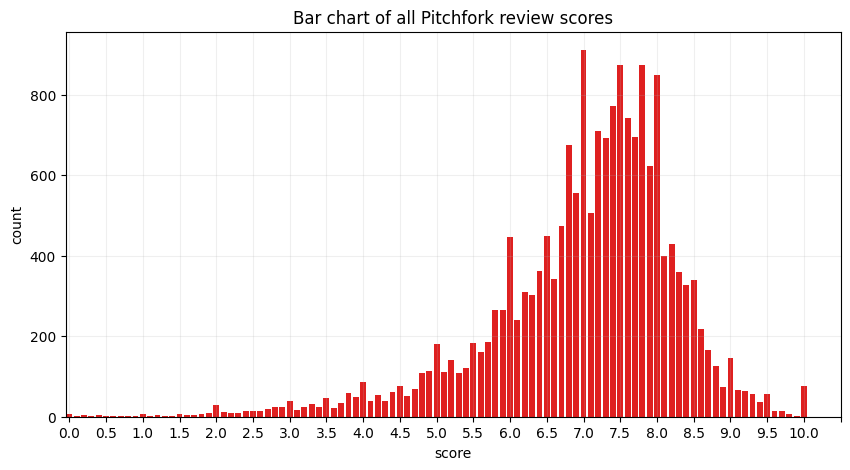

In [11]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(y='count', x='score', data=score_count, color='red' )
ax.set_xticks(range(0,110,5))
ax.grid(alpha=0.2)
plt.title('Bar chart of all Pitchfork review scores')
plt.show();


## Boxplot of all review scores

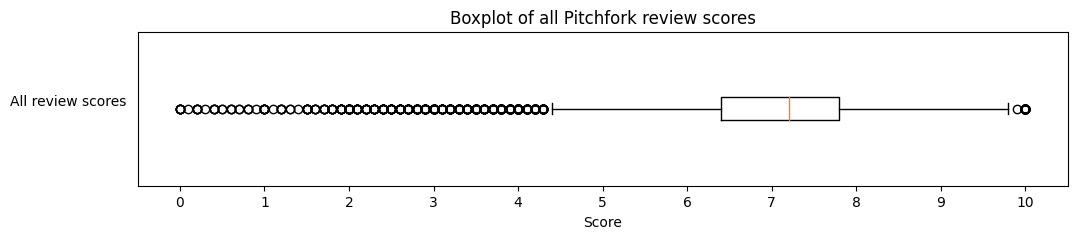

In [12]:
fig = plt.figure(figsize =(12, 2))
plt.boxplot(x=pitchfork_clean['score'], vert=False)

plt.title('Boxplot of all Pitchfork review scores')
plt.xlabel('Score')
plt.ylabel('All review scores', rotation=0, labelpad=50)
plt.yticks(range(0))
plt.xticks(range(11))
plt.show();

## Violinplot of all review scores

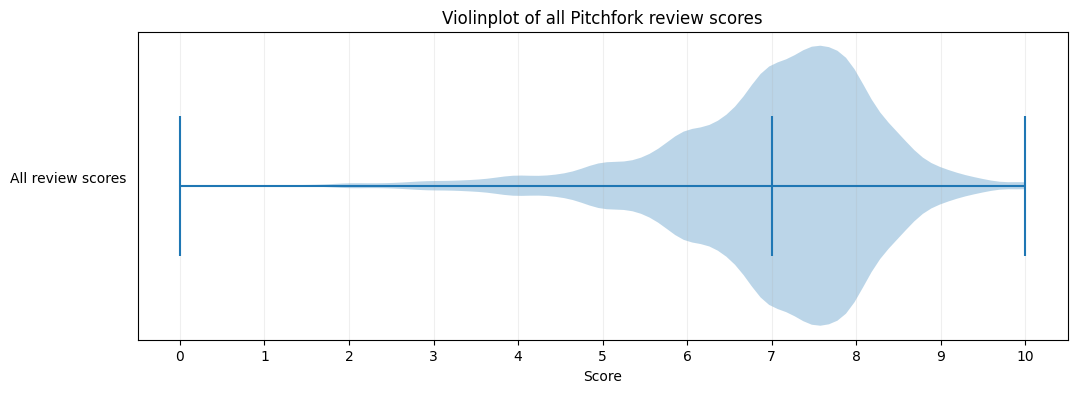

In [13]:
fig = plt.figure(figsize =(12, 4))
plt.violinplot(pitchfork_clean['score'], vert=False, showmeans=True)

plt.title('Violinplot of all Pitchfork review scores')
plt.xlabel('Score')
plt.ylabel('All review scores', rotation=0, labelpad=50)
plt.xticks(range(11))
plt.yticks(range(0))
plt.grid(alpha=0.2)
plt.show();

***

## Violinplots of scores by genre

Defining a function to create a new dataframe with only reviews that match the genre entered

In [14]:
def genre_df(genre):
    genre = pitchfork_clean[pitchfork_clean['genre'] == genre]
    return genre

In [15]:
electronic = genre_df('electronic')
jazz = genre_df('jazz')
folk_country = genre_df('folk/country')
metal = genre_df('metal')
pop_rnb = genre_df('pop/r&b')
rap = genre_df('rap')
experimental= genre_df('experimental')
rock = genre_df('rock')

### Creating the violinplots

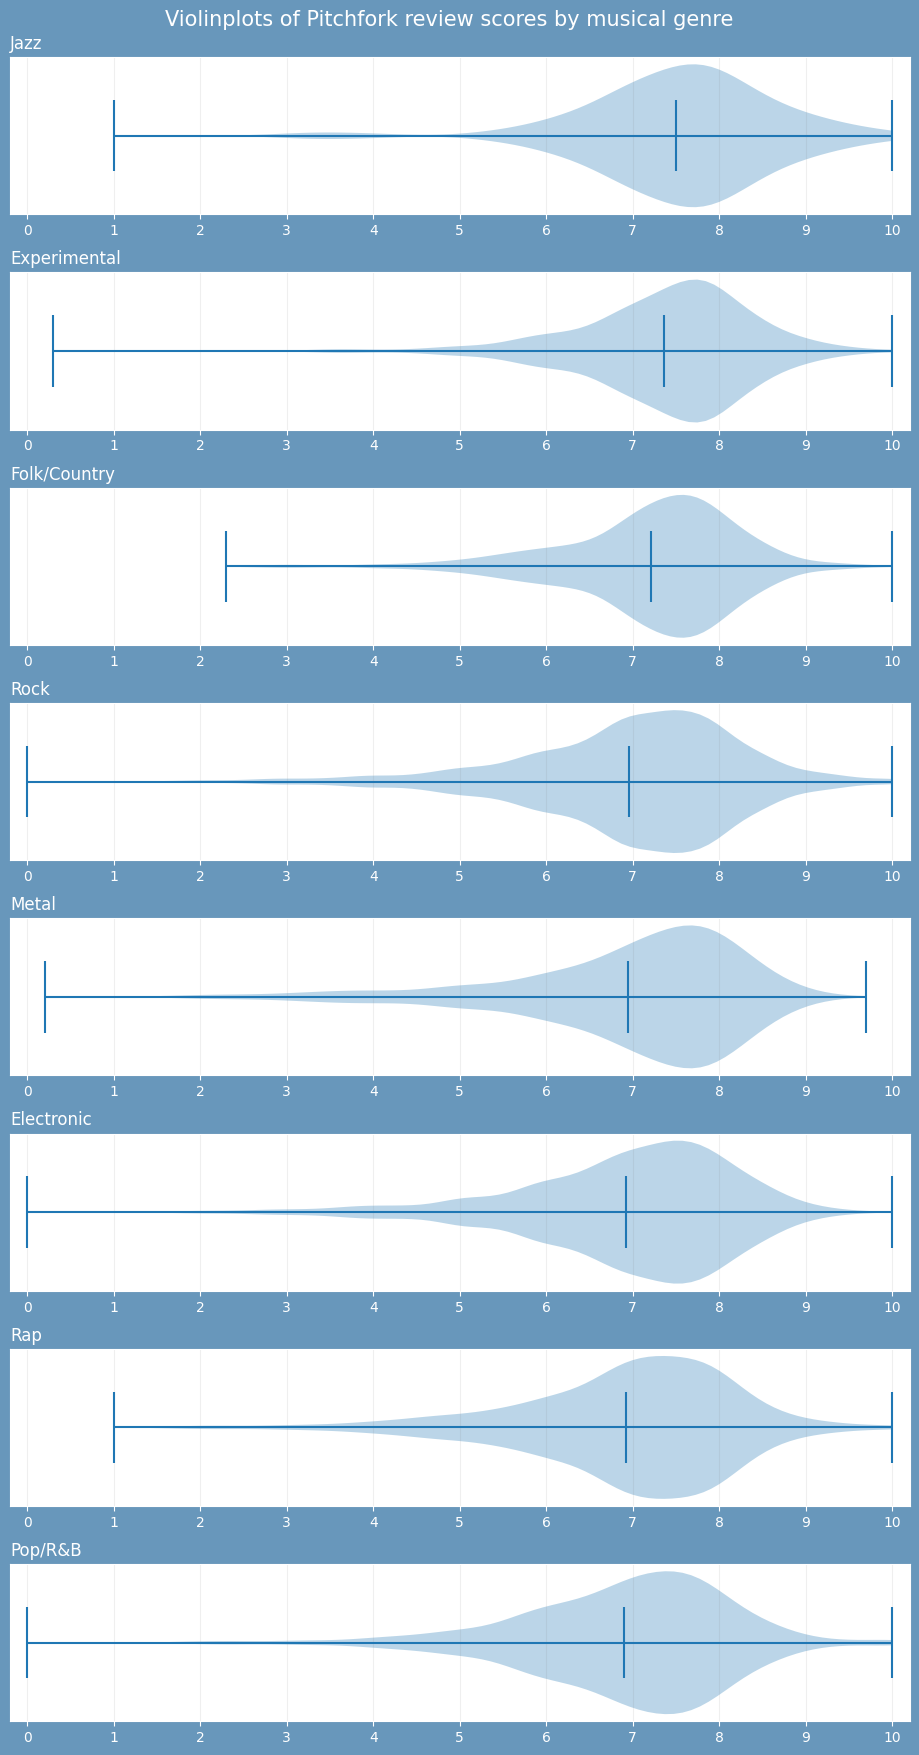

In [16]:
fig, axs = plt.subplots(nrows=8, figsize=(10,18))

fig.suptitle("Violinplots of Pitchfork review scores by musical genre", color='white', size=15)
fig.tight_layout(pad=2.08)
fig.patch.set_facecolor('#6897bb') # Border colours

x_min = -0.2   # Setting the values of the x axis
x_max = 10.2
for ax in axs:
    ax.set_xlim((x_min, x_max))

for ax in axs:   # Setting ticks and spines to be white
    ax.set_xticks(range(11))
    ax.set_yticks(range(0))
    ax.tick_params(axis='x', colors='white')   
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(alpha=0.12, color='grey')

for ax in axs:    # Face colours of each plot
    ax.set_facecolor('white')
    
# Loop through titles to add to plots
genre_titles = ['Jazz', 'Experimental', 'Folk/Country', 'Rock', 'Metal', 'Electronic', 'Rap', 'Pop/R&B']
for ax, title in zip(axs, genre_titles):
    ax.set_title(title, fontsize=12, loc='left', color='white')

# Loop through the new genre dataframes to create the plot
dfs = [jazz, experimental, folk_country, rock, metal, electronic, rap, pop_rnb]
for ax, dfs in zip(axs, dfs):
    ax.violinplot(dfs['score'], points=100, widths=0.3, showmeans=True, vert=False)

***

## Score reviews by year

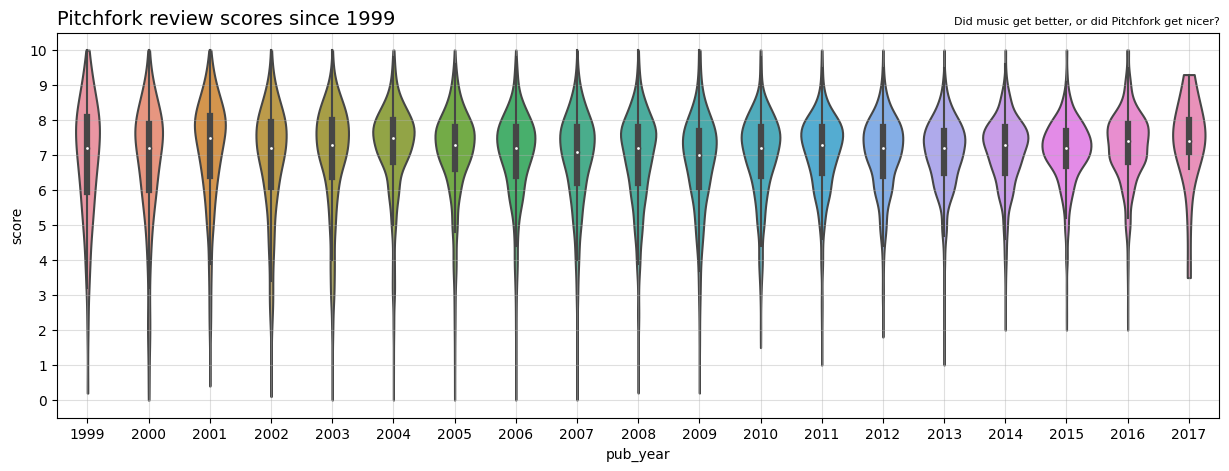

In [17]:
plt.figure(figsize=(15,5))
sns.violinplot(x='pub_year', y='score', data=pitchfork_clean, cut=0);
plt.title('Pitchfork review scores since 1999', size=14, loc='left')
plt.title('Did music get better, or did Pitchfork get nicer?', size=8, loc='right')
plt.yticks(range(11))
plt.grid(alpha=0.4)
plt.show()

***

## Reviews released on certain days of the week

In [18]:
weekday = pitchfork_clean['pub_weekday'].value_counts().reset_index().sort_values(by='pub_weekday', ascending=True)

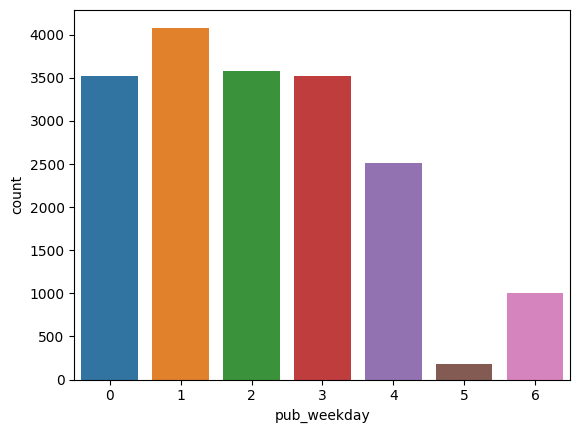

In [19]:
sns.barplot(x='pub_weekday', y='count', data=weekday);

***